## Dramatron

<img src="./dramatron.png" />

Implementation of [Dramatron](https://arxiv.org/pdf/2209.14958.pdf), Deepmind's generative story prompt model, which starts with a logline and progressively builds elements of a story ending with dialogue for each scene.

In [ ]:
import os
import promptz
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

llm = promptz.ChatGPT(
    model='gpt-4',
    api_key=os.environ['OPENAI_API_KEY'],
    org_id=os.environ['OPENAI_ORGANIZATION_ID'],
)

ef = OpenAIEmbeddingFunction(
    api_key=os.environ['OPENAI_API_KEY'],
    model_name="text-embedding-ada-002",
)

promptz.init(llm=llm, ef=ef, use_cache=False)

First define the pydantic types used to generate the story.

In [2]:
from typing import List
from pydantic import BaseModel, Field
from promptz import prompt, store, query


class Character(BaseModel):
    name: str = Field(..., unique=True)
    description: str = None


class Location(BaseModel):
    name: str = Field(..., unique=True)
    description: str = None


class SceneBeat(BaseModel):
    location: str
    plot_element: str
    description: str


class Story(BaseModel):
    logline: str
    title: str = None
    outline: List[SceneBeat] = None
    characters: List[Character] = None
    locations: List[Location] = None

Before generating a story lets define some examples to use as few shots in the prompts. We'll use the Star Wars examples defined in the paper.

In [3]:
star_wars = Story(
    title="Star Wars",
    logline='''
    A science - fiction fantasy about a naive but ambitious farm boy from a 
    backwater desert who discovers powers he never knew he had when he teams 
    up with a feisty princess, a mercenary space pilot and an old wizard warrior 
    to lead a ragtag rebellion against the sinister forces of the evil Galactic 
    Empire.
    ''',
    characters=[
        Character(
            name='Luke Skywalker',
            description='''
            Luke Skywalker is the hero. A naive farm boy, he will 
            discover special powers under the guidance of mentor 
            Ben Kenobi.
            ''',
        ),
        Character(
            name='Ben Kenobi',
            description='''
            Ben Kenobi is the mentor figure. A recluse Jedi warrior, 
            he will take Luke Skywalker as apprentice .
            ''',
        ),
        Character(
            name='Dartha Vader',
            description='''
            Darth Vader is the antagonist. As a commander of the 
            evil Galactic Empire, he controls space station The 
            Death Star.
            ''',
        ),
        Character(
            name='Princess Leia',
            description='''
            Princess Leia holds the plans of the Death Star. She is 
            feisty and brave. She will become Luke's friend.
            ''',
        ),
        Character(
            name='Han Solo',
            description='''
            Han Solo is a brash mercenary space pilot of the 
            Millenium Falcon and a friend of Chebacca. He will
            take Luke on his spaceship.
            ''',
        ),
        Character(
            name='Chewbacca',
            description='''
            Chewbacca is a furry and trustful monster. He is a friend 
            of Han Solo and a copilot on the Millemium Falcon.
            ''',
        ),
    ],
    locations=[
        Location(
            name='Farm',
            description='The farm is a desert planet where Luke Skywalker lives',
        ),
    ],
    outline=[
        SceneBeat(
            location='A farm on planet Tatooine',
            plot_element='The Ordinary World',
            description='Luke Skywalker is living a normal and humble life as a farm boy on his home planet.',
        ),
        SceneBeat(
            location='Desert of Tatooine',
            plot_element='Call to Adventure',
            description='''
            Luke is called to his adventure by robot R2-D2 and Ben Kenobi. 
            Luke triggers R2-D2's message from Princess Leia and is intrigued 
            by her message. When R2-D2 escapes to find Ben Kenobi, Luke follows 
            and is later saved by Kenobi, who goes on to tell Luke about his Jedi 
            heritage. Kenobi suggests that he should come with him.
            '''
        ),
        SceneBeat(
            location="Ben Kenobi's farm",
            plot_element='Refusal of the Call',
            description='''
            Luke refuses Kenobi, telling him that he can take Kenobi and the 
            droids as far as Mos Eisley Spaceport - but he can't possibly leave 
            his Aunt and Uncle behind for some space adventure.
            ''',
        ),
        SceneBeat(
            location='A farm on planet Tatooine',
            plot_element='Crossing the First Threshold',
            description='''
            When Luke discovers that the stormtroopers searching for the droids 
            would track them to his farm, he rushes to warn his Aunt and Uncle, 
            only to discover them dead by the hands of the Empire. When Luke 
            returns to Kenobi, he pledges to go with him to Alderaan and learn 
            the ways of the Force like his father before him.
            ''',
        ),
        SceneBeat(
            location='On spaceship The Millenium Falcon',
            plot_element='Tests, Allies, Enemies',
            description='''
            After Luke, Kenobi, and the droids hire Han Solo and Chewbacca to 
            transport them onto Alderaan, Kenobi begins Luke's training in the 
            ways of the Force. Wielding his father's lightsaber, Kenobi 
            challenges Luke. At first, he can't do it. But then Kenobi tells 
            Luke to reach out and trust his feelings. Luke succeeds.
            ''',
        ),
        SceneBeat(
            location='On spaceship The Millenium Falcon',
            plot_element='Approach to the Inmost Cave',
            description='''
            The plan to defeat the Galactic Empire is to bring the Death Star 
            plans to Alderaan so that Princess Leia's father can take them to 
            the Rebellion. However, when they arrive within the system, the 
            planet is destroyed. They come across the Death Star and are pulled 
            in by a tractor beam, now trapped within the Galactic Empire.
            ''',
        ),
        SceneBeat(
            location='On spacestation The Death Star',
            plot_element='Ordeal',
            description='''
            As Kenobi goes off to deactivate the tractor beam so they can escape, 
            Luke, Han, and Chewbacca discover that Princess Leia is being held on 
            the Death Star with them. They rescue her and escape to the Millennium 
            Falcon, hoping that Kenobi has successfully deactivated the tractor 
            beam. Kenobi later sacrifices himself as Luke watches Darth Vader 
            strike him down. Luke must now avenge his fallen mentor and carry on 
            his teachings.
            ''',
        ),
        SceneBeat(
            location='On spacestation The Death Star',
            plot_element='Reward',
            description='''
            Luke has saved the princess and retrieved the Death Star plans. 
            They now have the knowledge to destroy the Galactic Empire's 
            greatest weapon once and for all.
            ''',
        ),
        SceneBeat(
            location='On spaceship The Millenium Falcon',
            plot_element='The Road Back',
            description='''
            Luke, Leia, Han, Chewbacca, and the droids are headed to the hidden 
            Rebellion base with the Death Star plans. They are suddenly pursued 
            by incoming TIE-Fighters, forcing Han and Luke to take action to 
            defend the ship and escape with their lives - and the plans. They 
            race to take the plans to the Rebellion and prepare for battle.
            ''',
        ),
        SceneBeat(
            location='On fighter ship X-Wing',
            plot_element='The Resurrection',
            description='''
            The Rebels - along with Luke as an X-Wing pilot - take on the Death 
            Star. The Rebellion and the Galactic Empire wage war in an epic space 
            battle. Luke is the only X-Wing pilot that was able to get within the 
            trenches of the Death Star. But Darth Vader and his wingmen are in hot 
            pursuit. Just as Darth Vader is about to destroy Luke, Han returns and 
            clears the way for Luke. Luke uses the Force to guide his aiming as he 
            fires upon the sole weak point of the deadly Death Star, destroying it 
            for good.
            ''',
        ),
        SceneBeat(
            location='At the Rebellion base',
            plot_element='The Return',
            description='''
            Luke and Han return to the Rebellion base, triumphant, as they receive 
            medals for the heroic journey. There is peace throughout the galaxy - at 
            least for now.
            ''',
        ),
    ],
) 
    

The first step Dramatron defines in the generation process is writing a title based on a user defined logline. Instead of writing this manually, we can use a prompt to generate the title.

In [4]:
title = 'Uncut Gems'
logline = prompt(f'write a logline for {title}')

write a logline for Uncut Gems                                         
"An ambitious New York City jeweler with a gambling addiction sees a chance
to turn his luck around with a rare gem, but his unrelenting pursuit of the
ultimate win drags him deeper into a web of debt and danger."


Next, we define a function that writes a title based on the logline and then use it to add a title to a story instance.

In [5]:
def write_title(story: Story) -> str:
    return prompt(
        'Suggest a alternative, original and descriptive title for a known story.',
        story.logline,
        examples=[
            (
                star_wars.logline,
                "The Death Star's Menace"
            ),
            (
                "Residents of San Fernando Valley are under attack by flying saucers from outer space. The aliens are extraterrestrials who seek to stop humanity from creating a doomsday weapon that could destroy the universe and unleash the living dead to stalk humans who wander into the cemetery looking for evidence of the UFOs. The hero Jeff, an airline pilot, will face the aliens.",
                "The Day The Earth Was Saved By Outer Space."
            ),
        ],
        num_examples=2,
    )

story = Story(
    logline=logline,
)

title = write_title(story)
story.title = title
story

Suggest a alternative, original and descriptive title for a known
story.
"An ambitious New York City jeweler with a gambling addiction sees a chance
to turn his luck around with a rare gem, but his unrelenting pursuit of the
ultimate win drags him deeper into a web of debt and danger."
"Diamonds and Dice: An Obsession's Downfall"                           


Story(logline='"An ambitious New York City jeweler with a gambling addiction sees a chance to turn his luck around with a rare gem, but his unrelenting pursuit of the ultimate win drags him deeper into a web of debt and danger."', title='"Diamonds and Dice: An Obsession\'s Downfall"', outline=None, characters=None, locations=None)

Next we create a list of character objects based on the story logline and title. We then store them as embeddings so we can query them in later steps.

In [6]:
def create_characters(story: Story, n=5) -> List[Character]:
    return prompt(
        f'Create {n} characters for a story.',
        input=story.logline,
        output=List[Character],
        examples=[
            (
                star_wars.logline,
                star_wars.characters,
            ),
        ],
    )

characters = create_characters(story)
store(characters)

Create 5 characters for a story.                                       
"An ambitious New York City jeweler with a gambling addiction sees a chance
to turn his luck around with a rare gem, but his unrelenting pursuit of the
ultimate win drags him deeper into a web of debt and danger."
                                                                           
[{"name": "Howard Ratner", "description": "Howard Ratner is the protagonist, an
ambitious New York City jeweler with a gambling addiction, he's always looking
for the next big score."},
{"name": "Julia", "description": "Julia is Howard's girlfriend who works in his
shop and supports him throughout his destructive habits."},
{"name": "Arno", "description": "Arno is Howard's brother-in-law and loan shark,
a constant threat looming over Howard."},
{"name": "Kevin Garnett", "description": "Kevin Garnett is a client of Howard's,
who becomes obsessed with a rare gem that Howard acquires."},
{"name": "Demany", "description": "Demany is H

id       type           name  \
0  92f82580-3826-4299-a48e-73f450f6e0c6  character  Howard Ratner   
1  7715413b-3489-45bd-8683-4250da5ad17a  character          Julia   
2  06ffd826-a046-49be-8a05-76201a54144a  character           Arno   
3  30cfbbb9-0d88-4fc8-97d4-7f7ae3ba3c23  character  Kevin Garnett   
4  62fa2b1b-d77b-4a88-89ea-b7b0e2970e3e  character         Demany   

                                         description  
0  Howard Ratner is the protagonist, an ambitious...  
1  Julia is Howard's girlfriend who works in his ...  
2  Arno is Howard's brother-in-law and loan shark...  
3  Kevin Garnett is a client of Howard's, who bec...  
4  Demany is Howard's associate who brings in cli...

Now we can generate a plot outline from the story logline, title, and characters. This is just a string, which tends to produce better results for this kind of output.

In [7]:
def write_beats(story: Story, n=10) -> List[SceneBeat]:
    return prompt(
        f'''
        Write a sequence of {n} scene beats for a story a hero's journey structure.
        ''',
        input=dict(logline=story.logline, characters=story.characters),
        output=List[SceneBeat],
        examples=[
            (
                dict(logline=star_wars.logline, characters=star_wars.characters),
                star_wars.outline,
            ),
        ],
    )

beats = write_beats(story)
story.outline = beats.objects
beats

                                                                           
Write a sequence of 10 scene beats for a story a hero's journey structure.      
                                                                            
{'logline': '"An ambitious New York City jeweler with a gambling addiction
sees a chance to turn his luck around with a rare gem, but his unrelenting
pursuit of the ultimate win drags him deeper into a web of debt and danger."',
'characters': {}}
[{"location": "New York City Jewelry Shop", "plot_element": "The Ordinary
World", "description": "Howard Ratner, a charismatic New York City jeweler,
juggles business, family, and adversaries on all sides while managing his
addiction to gambling."}, {"location": "Howard's Jewelry Shop", "plot_element":
"Call to Adventure", "description": "Howard receives a rare black opal from
Ethiopia, sees it as the solution to all his mounting debts and a chance to
escape from the tight corner he has found himself in."}, {"loca

type                    location                  plot_element  \
0   scenebeat  New York City Jewelry Shop            The Ordinary World   
1   scenebeat       Howard's Jewelry Shop             Call to Adventure   
2   scenebeat          Howard's Apartment           Refusal of the Call   
3   scenebeat  New York City Jewelry Shop  Crossing the First Threshold   
4   scenebeat               New York City        Tests, Allies, Enemies   
5   scenebeat               Auction House   Approach to the Inmost Cave   
6   scenebeat               Auction House                        Ordeal   
7   scenebeat          Howard's Apartment                        Reward   
8   scenebeat       Howard's Jewelry Shop                 The Road Back   
9   scenebeat              Betting Center              The Resurrection   
10  scenebeat       Howard's Jewelry Shop                    The Return   

                                          description  
0   Howard Ratner, a charismatic New York City jew...  
1   Howard receives a rare black opal from Ethiopi...  
2   Despite knowing the opportunity the opal repre...  
3   Convicted by his greed and desperation, Howard...  
4   Howard constantly faces threats and intimidati...  
5   Howard, unsatisfied with the amount Garnett of...  
6   Howard's plan backfires when Garnett doesn't b...  
7   Desperate, Howard convinces Garnett to buy the...  
8   Howard uses the money from Garnett to place a ...  
9   Howard's bet ends up successful, and for a mom...  
10  Just as Howard is celebrating his victory, one...

Next we extract the scene 'beats' from the plot outline generated in the previous step. These are the main events that happen in the story.

Each scene beat has a location name so we can use this to extract location objects. These are stored like characters. For some reason the examples in the paper don't use locations from Star Wars. They also use the story logline and just the name of the location from the scene beat instead of the description of the scene. It's unclear why these decisions were made, but for consistency we'll do the same.

In [8]:
def extract_locations(story: Story) -> List[Location]:
    return prompt(
        '''
        Generate a location based on the story logline and location name. 
        ''',
        input=[dict(logline=story.logline, name=beat.location) for beat in story.outline],
        output=Location,
        examples=[
            (
                dict(
                    logline="Morgan adopts a new cat, Misterio, who sets a curse on anyone that pets them.",
                    name="The Adoption Center",
                ),
                Location(
                    name="The Adoption Center",
                    description='''
                    The Adoption Center is a sad place, especially for an unadopted 
                    pet. It is full of walls and walls of cages and cages. Inside of 
                    each is an abandoned animal, longing for a home. The lighting is 
                    dim, gray, buzzing fluorescent.
                    ''',
                )
            ),
            (
                dict(
                    logline="James finds a well in his backyard that is haunted by the ghost of Sam.",
                    name="The Well",
                ),
                Location(
                    name="The Well",
                    description='''
                    The well is buried under grass and hedges. It is at least 
                    twenty feet deep, if not more and it is masoned with stones. 
                    It is 150 years old at least. It stinks of stale, standing 
                    water, and has vines growing up the sides. It is narrow enough 
                    to not be able to fit down if you are a grown adult human.
                    ''',
                )
            ),
            (
                dict(
                    logline="Mr. Dorbenson finds a book at a garage sale that tells the story of his own life. And it ends in a murder! ",
                    name="The Garage Sale",
                ),
                Location(
                    name="The Garage Sale",
                    description='''
                    It is a garage packed with dusty household goods and antiques. 
                    There is a box at the back that says FREE and is full of paper 
                    back books.
                    ''',
                )
            ),
        ],
        num_examples=3,
    )

locations = extract_locations(story)
store(*locations)

                                                                           
Generate a location based on the story logline and location name.               
                                                                            
{'logline': '"An ambitious New York City jeweler with a gambling addiction
sees a chance to turn his luck around with a rare gem, but his unrelenting
pursuit of the ultimate win drags him deeper into a web of debt and danger."',
'name': 'New York City Jewelry Shop'}
{"name": "New York City Jewelry Shop", "description": "\n
A dazzling store bathed in shiny lights reflecting off of gold and diamond.\n
Luxury is apparent everywhere from the polished oak counters to the velvet-lined
showcases.\n                    However, a closer look reveals the underlying
tension. There is a certain disarray\n                    unnoticed by the
casual observer – a desperate hint of chaos amidst the opulence.\n
"}
                                                           

id       type  \
0   92f82580-3826-4299-a48e-73f450f6e0c6  character   
1   7715413b-3489-45bd-8683-4250da5ad17a  character   
2   06ffd826-a046-49be-8a05-76201a54144a  character   
3   30cfbbb9-0d88-4fc8-97d4-7f7ae3ba3c23  character   
4   62fa2b1b-d77b-4a88-89ea-b7b0e2970e3e  character   
5   52b59d7c-afef-458a-863d-cb0c62109aec        NaN   
6   7d86fe5d-9f35-40ce-b1f2-72362c044979        NaN   
7   c323cc0e-73d0-4096-a466-b094d4989ccc        NaN   
8   dddf78ae-03ab-4483-91b4-57a810ed96bf        NaN   
9   24bf955f-d3b7-4b3f-8794-7aa5518d025b        NaN   
10  4df014e7-b544-40c7-8628-1709615256d5        NaN   
11  6bec782c-b6fb-4fb9-8f4d-419d146a3d08        NaN   
12  8f1017a7-af81-403f-9b8b-93805cd945d2        NaN   
13  30b9308e-274c-40c7-8ecc-e2dfeacfec5e        NaN   
14  25b6bf79-7373-40e0-b8f9-51d6536bd281        NaN   
15  aa99aba4-d28d-4129-8177-999b30bc7c97        NaN   

                          name  \
0                Howard Ratner   
1                        Julia   
2                         Arno   
3                Kevin Garnett   
4                       Demany   
5   New York City Jewelry Shop   
6        Howard's Jewelry Shop   
7           Howard's Apartment   
8   New York City Jewelry Shop   
9                New York City   
10               Auction House   
11               Auction House   
12          Howard's Apartment   
13       Howard's Jewelry Shop   
14              Betting Center   
15       Howard's Jewelry Shop   

                                          description  
0   Howard Ratner is the protagonist, an ambitious...  
1   Julia is Howard's girlfriend who works in his ...  
2   Arno is Howard's brother-in-law and loan shark...  
3   Kevin Garnett is a client of Howard's, who bec...  
4   Demany is Howard's associate who brings in cli...  
5   \n                    A dazzling store bathed ...  
6   \n                    Howard's Jewelry Shop is...  
7   \n                    Howard's Apartment is a ...  
8   \n                    A compact, crowded space...  
9   \n                    New York City is a bustl...  
10  \n                    The Auction House is an ...  
11  \n                    The auction house is a t...  
12  \n                    Howard's Apartment in Ne...  
13  \n                    Howard's Jewelry Shop is...  
14  \n                    The Betting Center is a ...  
15  \n                    Howard's Jewelry Shop is...

Finally, we can write a script for each scene using the generated scene beats and the characters and locations we generated earlier. Characters and locations are queried using the scene beat data so that the most relevant entries are found using the stored embeddings. Again, the example follows the paper.

In [9]:
def write_script(story: Story, n=None) -> str:
    inputs = [
        dict(
            location=query(beat.location, where={'type': 'location'}).first,
            characters=query(beat.description, where={'type': 'character'}).objects,
            plot_element=story.outline[i].plot_element,
            logline=story.logline,
            previous_beat=story.outline[i-1].description if i > 0 else None,
            beat=story.outline[i].description,
        ) for i, beat in enumerate(story.outline[:n or len(story.outline)])
    ]
    
    return prompt(
        '''
        Write a script based on the characters and locations
        and the events described in the scene beat.
        ''',
        input=inputs,
        examples=[
            (
                dict(
                    location=Location(
                        name='Cockpit of an airplane',
                        description='''
                        Cockpit of a modern passenger airplane, American Flight 812.
                        ''',
                    ),
                    characters=[
                        Character(
                            name='Jeff',
                            description='''
                            Jeff is the hero. A man in his early forties, he tries 
                            to stay calm in all circumstance. Jeff is now a airline 
                            pilot.
                            ''',
                        ),

                        Character(
                            name='Danny',
                            description='''
                            Danny, a young airplane pilot in his thirties, is eager 
                            to learn but can quickly lose his composture. Danny is 
                            enamored of Edith.
                            ''',
                        ),
                        Character(
                            name='Edith',
                            description='''
                            Edith, an experienced stewardess with a good sense of 
                            humour, is trustworthy and dependable. Edith likes to 
                            tease Danny.
                            ''',
                        ),
                    ],
                    plot_element=" Crossing the First Threshold",
                    logline="Residents of San Fernando Valley are under attack by flying saucers from outer space. The aliens are extraterrestrials who seek to stop humanity from creating a doomsday weapon that could destroy the universe and unleash the living dead to stalk humans who wander into the cemetery looking for evidence of the UFOs. The hero Jeff, an airline pilot, will face the aliens.",
                    previous_beat='''
                    Flight captain Jeff reluctantly leaves his wife Paula to go 
                    for a two-day flight.
                    ''',
                    beat='''
                    At the cockpit, flight captain Jeff is preoccupied by the 
                    flying saucer appearances and graveyard incidents in his home 
                    town, where he left wis wife Paula. Without success, co-pilot 
                    Danny and stewardess Edith try to reassure him.
                    ''',
                ),
                '''
                DANNY
                You're mighty silent this trip, Jeff.
                JEFF
                Huh?
                DANNY
                You haven't spoken ten words since takeoff.
                JEFF
                I guess I'm preoccupied, Danny.
                DANNY
                We've got thirty-three passengers back there that have time to 
                be preoccupied. Flying this flybird doesn't give you that 
                opportunity.
                JEFF
                I guess you're right, Danny.
                DANNY
                Paula?
                JEFF
                Yeah.
                DANNY
                There's nothing wrong between you two?
                JEFF
                Oh no, nothing like that. Just that I'm worried, she being there 
                alone and those strange things flying over the house and those 
                incidents in the graveyard the past few days. It's just got me 
                worried.
                DANNY
                Well, I haven't figured out those crazy skybirds yet but I give 
                you fifty to one odds the police have figured out that cemetery 
                thing by now.
                ( Enter EDITH )
                JEFF
                I hope so.
                EDITH
                If you're really that worried Jeff why don't you radio in and 
                find out? Mac should be on duty at the field by now. He could call 
                Paula and relay the message to you.
                DANNY
                Hi Edith.
                EDITH
                Hi Silents. I haven't heard a word from this end of the plane since 
                we left the field.
                DANNY
                Jeff's been giving me and himself a study in silence.
                EDITH
                You boys are feudin'?
                JEFF
                Oh no Edie, nothing like that.
                DANNY
                Hey Edie, how about you and me balling it up in Albuquerque?
                EDITH
                Albuquerque? Have you read that flight schedule Boy?
                DANNY
                What about it?
                EDITH
                We land in Albuquerque at 4 am. That's strictly a nine o'clock 
                town.
                DANNY
                Well I know a friend that ll help us --
                EDITH
                Let's have a problem first, huh Danny.
                DANNY
                Ah he's worried about Paula.
                EDITH
                I read about that cemetery business. I tried to get you kids to 
                not buy too near one of those things. We get there soon enough as 
                it is.
                DANNY
                He thought it'd be quiet and peaceful there.
                EDITH
                No doubt about that. It's quiet alright, like a tomb. I'm sorry 
                Jeff, that was a bad joke.
                '''
            )
        ]
    )


script = []
for scene in write_script(story, n=2):
    script.append(scene)

                                                                           
Write a script based on the characters and locations                            
and the events described in the scene beat.                                     
                                                                            
{'location': {'type': nan, 'id': 'dddf78ae-03ab-4483-91b4-57a810ed96bf',
'name': 'New York City Jewelry Shop', 'description': '\n                    A
compact, crowded space filled with the glitter of diamonds \n
and precious stones, the New York City Jewelry Shop emanates luxury. \n
Glossy glass cases display a myriad of jewelry, shining under the \n
carefully positioned lights. A beaded curtain separates the front of \n
the shop, cluttered with customers, from the backroom where the jeweler \n
meticulously examines each gem with a loupe, a world of debt and danger\n
hidden behind his ambition.\n'}, 'characters': [{'type': 'character', 'id':
'92f82580-3826-4299-a48e-73f450f6e

That covers the basic implementation described in the paper, but we can extend this by breaking the generated scripts into storyboards and then illustrating those frames with an image model.

In [10]:
script[0]

'"INT. NEW YORK CITY JEWELRY SHOP - DAY\n\nHOWARD RATNER, a high-energy, charismatic jeweler is scanning a raw gem with his jeweler\'s loupe. A murmur from the customers rises as KEVIN GARNETT, basketball star, enters the shop. \n\nHoward looks up, dropping the gem, and wipes his fingers on his apron. \n\nHOWARD\nKevin Garnett! The man himself. What can I do for you?\n\nGarnett shrugs, his eyes drawn to the shining displays.\n\nGARNETT\nI was told you had something special in today.\n\nHoward glances back to where he was sitting, eyeing the raw gem he was examining. He grins confidently.\n\nHOWARD\nI just might, but it\'ll cost you!\n\nSuddenly, a threatening figure makes his way through the crowd - ARNO, a muscular man with an unnerving sense of calm. \n\nARNO\nHoward, a word.\n\nHoward glances back at Garnett.\n\nHOWARD\nExcuse me, gotta deal with this. JULIA, take care of Mr. Garnett for me.\n\nJulia, a sharp-eyed young woman, nods and steps forward as Howard disappears behind the b

In [11]:
def storyboard(script, beat, logline):
    return prompt(
        '''
        Break the script down into 6-12 frames and describe each frame
        so that it can be illustrated. Use any info about the story,
        characters, locations, etc. that you need to describe the frames. 
        ''',
        dict(
            logline=logline,
            location=query(beat.location, where={'type': 'location'}).first,
            characters=query(beat.description, where={'type': 'character'}).objects,
            script=script,
        ),
        List[str],
    )

frames = storyboard(script[0], story.outline[0], story.logline)
frames

                                                                           
Break the script down into 6-12 frames and describe each frame                  
so that it can be illustrated. Use any info about the story,                    
characters, locations, etc. that you need to describe the frames.               
                                                                            
{'logline': '"An ambitious New York City jeweler with a gambling addiction
sees a chance to turn his luck around with a rare gem, but his unrelenting
pursuit of the ultimate win drags him deeper into a web of debt and danger."',
'location': {'type': nan, 'id': 'dddf78ae-03ab-4483-91b4-57a810ed96bf', 'name':
'New York City Jewelry Shop', 'description': '\n                    A compact,
crowded space filled with the glitter of diamonds \n                    and
precious stones, the New York City Jewelry Shop emanates luxury. \n
Glossy glass cases display a myriad of jewelry, shining under the \n
car

type                                             output
0  str  Frame 1: In a bustling New York City jewelry s...
1  str  Frame 2: The customers create a murmur as bask...
2  str  Frame 3: Howard cleans his hands on his apron ...
3  str  Frame 4: Kevin shrugs, his attention drawn to ...
4  str  Frame 5: Howard, grinning confidently, glances...
5  str  Frame 6: The crowd parts as a threatening figu...
6  str  Frame 7: Howard glances back at Garnett, askin...
7  str  Frame 8: Howard and Arno disappear behind a be...
8  str  Frame 9: Demany, a stylish and smooth-talking ...
9  str  Frame 10: Through Garnett's interaction with J...

Frame 1: In a bustling New York City jewelry shop, Howard Ratner, a high-energy, charismatic jeweler, scans a raw gem with his jeweler's loupe.


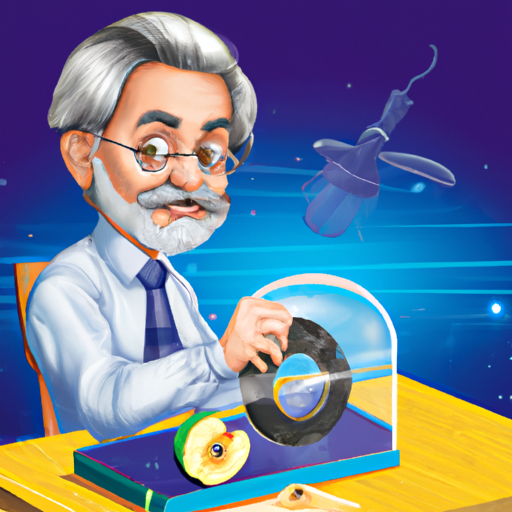

Frame 2: The customers create a murmur as basketball star Kevin Garnett enters the shop, causing Howard to look up and accidentally drop the gem.


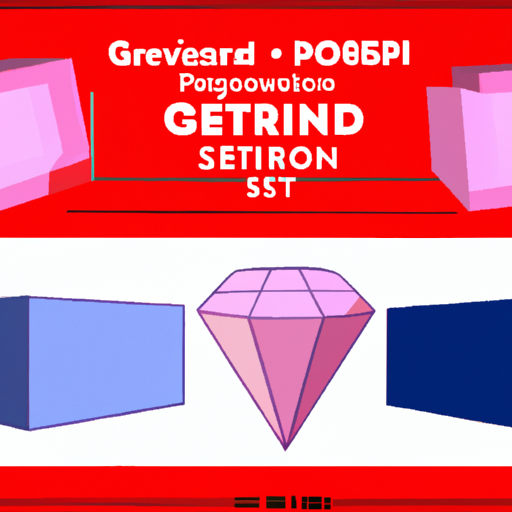

Frame 3: Howard cleans his hands on his apron and shows excitement, greeting Kevin with enthusiasm.


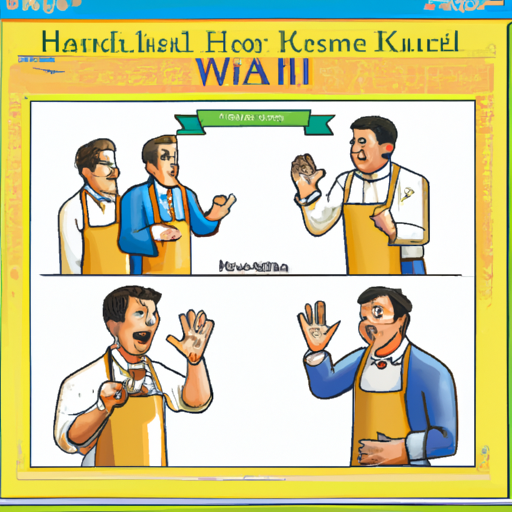

Frame 4: Kevin shrugs, his attention drawn to the shining displays of jewelry.


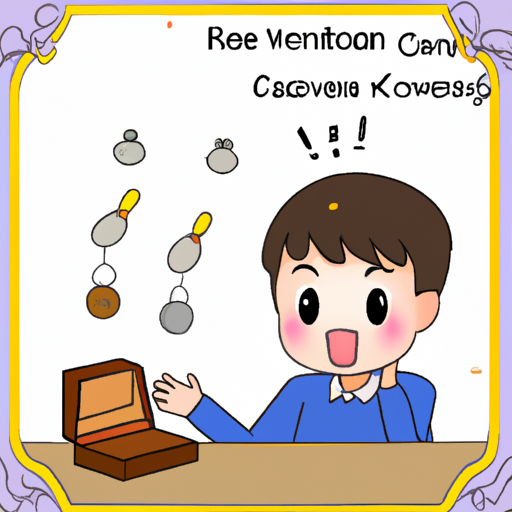

Frame 5: Howard, grinning confidently, glances at the raw gem he was previously examining, alluding to something special he might have for Garnett.


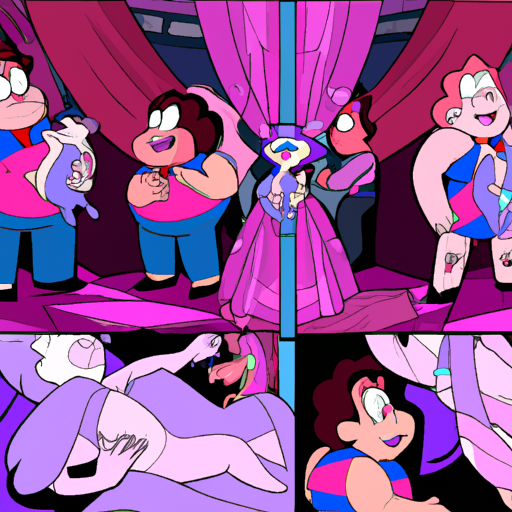

: 

: 

In [12]:
from promptz import DALL_E

dall_e = DALL_E(
    api_key=os.environ['OPENAI_API_KEY'],
    org_id=os.environ['OPENAI_ORGANIZATION_ID'],
)

def draw_frames(frames):
    return prompt(
        '''
        Illustrate the action and scene described in the frame. 
        ''',
        frames,
        llm=dall_e,
        silent=True,
    )

descriptions = frames['output'].to_list()
images = draw_frames(descriptions)

import base64
from IPython.display import display, Image

for image, description in zip(images, descriptions):
    image_bytes = base64.b64decode(image)
    print(description)
    display(Image(data=image_bytes))